# Лабораторная работа №3. Глубокое обучение
**Задача**

В лабораторной вам предлагается решить задачу классификации изображений на два класса: хотдог и не-хотдог.    

**Данные**

Вы будете работать с подмножеством того самого Imagenet'a, который обеспечил прорыв в глубоком обучении. Изображения hotdog'a соответствуют классу hotdog в Imagenet'e, изображения для not_hotdog -- случайные изображения из остальных классов. В обучающей выборке 1671 изображений (hotdog -- 708, not_hotdog -- 963). В тестовой выборке 325 изображений, пропорция классов примерно такая же как и в обучающей выборке. Ground truth разметка для тестовой выборки не дана. 
Сами данные: https://drive.google.com/file/d/13V_J8z1VOCDIJLtlnaFrNdmOgPxU5pRt/view?usp=sharing

**Что нужно сделать**

[max 2 балла]    Обучите классический алгоритм машинного обучения для этих данных (например, SVM, Random Forest или Gradient Boosting Trees), используя RGB-интенсивности пикселей в качестве входного вектора для классификации. Оцените ошибку.

[max 3 балла]    Обучите свёрточную нейронную сеть на этих данных и оцените ошибку. Можно это делать на базе одного из базовых туториалов из фреймворка по глубокому обучению. Фреймворк можно использовать любой, рекомендуется PyTorch.

[max 3 балла]    Обучите линейный SVM на features от предобученного VGG и оцените ошибку. А именно надо взять выходы от предпоследнего полносвязного слоя (то есть не того, который выдаёт предсказание на 1000 классов, а перед ним -- в котором 4096 нейронов) и использовать их в качестве входов для линейного SVM. В качестве сети VGG можно взять любой из вариантов (например, VGG-16 или VGG-19).

[max 2 балла]    Выберете, как вы считаете, наиболее перспективный подход для этой задачи (выбор обоснуйте) и улучшите его точность. Классифицируете тестовую выборку, используя ваш финальный классификатор.


## Data

### Import


In [34]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import glob
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from google.colab import drive
import time
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tensorflow import keras
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten
from keras.applications.vgg16 import VGG16
from keras.models import Model
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from tensorflow.keras.applications.vgg16 import preprocess_input,decode_predictions
from tensorflow.keras import layers, models
from random import randint
import warnings
warnings.filterwarnings('ignore')

In [2]:
drive.mount('/content/drive')

hotdogs = glob.glob('/content/drive/MyDrive/все подряд/учеба/магистратура/ML/Lab3/train/hotdog/*.jpg', recursive=True) 
notHotdogs = glob.glob('/content/drive/MyDrive/все подряд/учеба/магистратура/ML/Lab3/train/not_hotdog/*.jpg', recursive=True)
testData = glob.glob('/content/drive/MyDrive/все подряд/учеба/магистратура/ML/Lab3/test/*.jpg', recursive=True) 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Preprocessing

In [3]:
size = 224
img = cv2.imread(hotdogs[34]) 
img = np.array(img)
img.shape

(375, 500, 3)

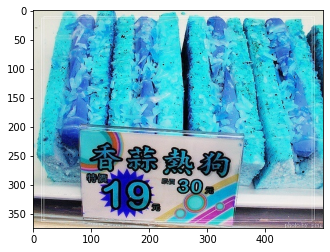

In [4]:
plt.imshow(img)

In [7]:
def rotateImage(img, angle):
    (rows, cols, ch) = img.shape
    M = cv2.getRotationMatrix2D((cols/2,rows/2), angle, 1)
    return cv2.warpAffine(img, M, (cols,rows))
    
    
def loadBlurImg(path, imgSize):
    img = cv2.imread(path)
    angle = np.random.randint(0, 360)
    img = rotateImage(img, angle)
    img = cv2.blur(img,(5,5))
    img = cv2.resize(img, imgSize)
    return img

def loadImgClass(classPath, classLable, imgSize):
    x = []
    y = []
    
    for path in classPath:
        img = loadBlurImg(path, imgSize)        
        x.append(img)
        y.append(classLable)
        
    return x, y

def loadData(img_size, hotdogs, notHotdogs):    
    imgSize = (img_size, img_size)
    xHotdog, yHotdog = loadImgClass(hotdogs, 0, imgSize)
    xNotHotdog, yNotHotdog = loadImgClass(notHotdogs, 1, imgSize)
    print("There are", len(xHotdog), "hotdog images")
    print("There are", len(xNotHotdog), "not hotdog images")
    
    X = np.array(xHotdog + xNotHotdog)
    y = np.array(yHotdog + yNotHotdog)
    
    return X, y

def loadTestData(img_size, testData):
    imgSize = (img_size, img_size)
    x = []
    for path in testData:
        img = loadBlurImg(path, imgSize)        
        x.append(img)
    
    return np.array(x, dtype='object')

In [8]:
scaled_X, y = loadData(size, hotdogs, notHotdogs)
X_overall_test = loadTestData(size, testData)
y = to_categorical(y)

print("y shape", y.shape)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, 
                                                    test_size=0.25, 
                                                    random_state=1046)

print("train shape X", X_train.shape)
print("train shape y", y_train.shape)
print("Test shape X:", X_test.shape)
print("Test shape y: ", y_test.shape)

inputShape = (size, size, 3)

There are 708 hotdog images
There are 963 not hotdog images
y shape (1671, 2)
train shape X (1253, 224, 224, 3)
train shape y (1253, 2)
Test shape X: (418, 224, 224, 3)
Test shape y:  (418, 2)


## ML Algorithms

### RandomForest

In [9]:
rfc = RandomForestClassifier(max_depth=10, random_state=0)
X_train_rf = X_train.reshape(X_train.shape[0],3*size*size)
X_test_rf = X_test.reshape(X_test.shape[0],3*size*size)
rfc.fit(X_train_rf, y_train)

RandomForestClassifier(max_depth=10, random_state=0)

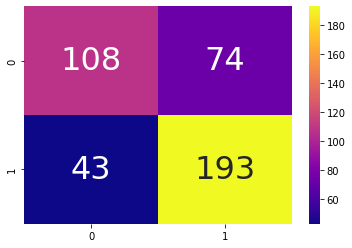

In [10]:
pred_rf = rfc.predict(X_test_rf)
pred_rf = np.argmax(pred_rf, axis=-1)
labels = np.argmax(y_test, axis=-1)
cm = confusion_matrix(labels, pred_rf)
sns.heatmap(cm,cmap='plasma',annot=True,fmt='g',annot_kws={"size": 32})

### GradientBoosting

In [ ]:
gbc = GradientBoostingClassifier(n_estimators=10)
gbc.fit(X_train_rf, np.argmax(y_train, axis=-1))

In [ ]:
pred_gbs = rfc.predict(X_test_rf)
pred_gbs = np.argmax(pred_gbs, axis=-1)
labels = np.argmax(y_test, axis=-1)
cm = confusion_matrix(labels, pred_gbs)
sns.heatmap(cm,cmap='plasma',annot=True,fmt='g',annot_kws={"size": 32})

Среди классических моделей машинного обучения RandomForest показывает себя вполне достойно

## DeepLearning 


In [39]:
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    ## Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [40]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 kernel_initializer='he_normal',
                 input_shape=inputShape))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(2, activation='softmax'))

model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.Adam(lr=1e-4),
              metrics=['accuracy'])

start = time.time()

model.summary()

callbacks = [EarlyStopping(monitor='val_loss', patience=3),
             ModelCheckpoint(filepath='model.h5', monitor='val_acc', save_best_only=True)]

history = model.fit(X_train, y_train,
                    batch_size=32,
                    epochs=5, 
                    callbacks=callbacks,
                    verbose=0,
                    validation_data=(X_test, y_test))

end = time.time()
print('Execution time: ', end-start)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 111, 111, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 54, 54, 64)        0

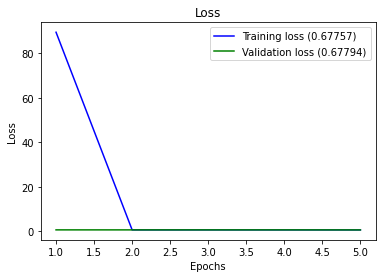

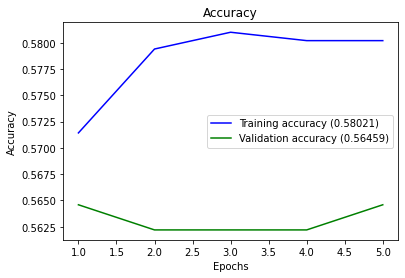

In [41]:
plot_history(history)

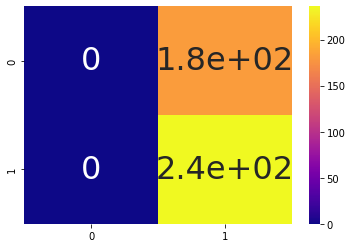

In [42]:
pred = model.predict(X_test)
pred = np.argmax(pred, axis=-1)
labels = np.argmax(y_test, axis=-1)
cm = confusion_matrix(labels, pred)
sns.heatmap(cm,cmap='plasma',annot=True,annot_kws={"size": 32})

Можем заметить, что модель приходит к решению с постоянным ответом НеХотдог, поэтому отметаем эту модель среди претендентов на итоговую выборку

## VGG


In [14]:
def vgg16_model():
  model = VGG16(weights='imagenet', include_top=True)

  x = Dense(1024, activation='relu')(model.layers[-4].output)
  x = Dropout(0.7)(x)
  x = Dense(512, activation='relu')(x)
  x = Dropout(0.5)(x)
  x = Dense(2, activation='softmax')(x)
  model = Model(model.input, x)

  return model

vgg_model = vgg16_model()

In [16]:
vgg_x_train = np.array([np.array(elem, dtype='object') for elem in X_train], dtype='object')
vgg_x_train = preprocess_input(vgg_x_train)

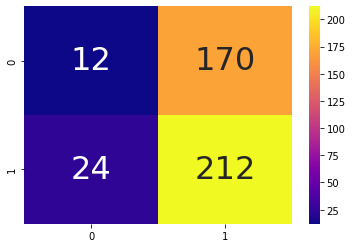

In [20]:
vgg_pred = vgg_model.predict(X_test)
vgg_pred = np.argmax(vgg_pred, axis=-1)

labels = np.argmax(y_test, axis=-1)
cm = confusion_matrix(labels, vgg_pred)
sns.heatmap(cm,cmap='plasma',annot=True,fmt='g',annot_kws={"size": 32})

VGG очень мощный инструмент, но в данном конкретном случае показывает не лучшие результаты

## Results

Исходя из всех предыдущих результатов для итоговой predict выбран RandomForest

In [15]:
X_overall_test = X_overall_test.reshape(X_overall_test.shape[0],3*size*size)
overall_predict = np.argmax(rfc.predict(X_overall_test), axis=-1)
overall_predict

array([1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1,
       1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1,
       1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1,
       1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1,
       1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0,
       1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0,

In [19]:
print(f"Всего хотдогов {np.count_nonzero(overall_predict == 0)}")
print(f"Всего НЕхотдогов {np.count_nonzero(overall_predict == 1)}")

Всего хотдогов 127
Всего НЕхотдогов 198


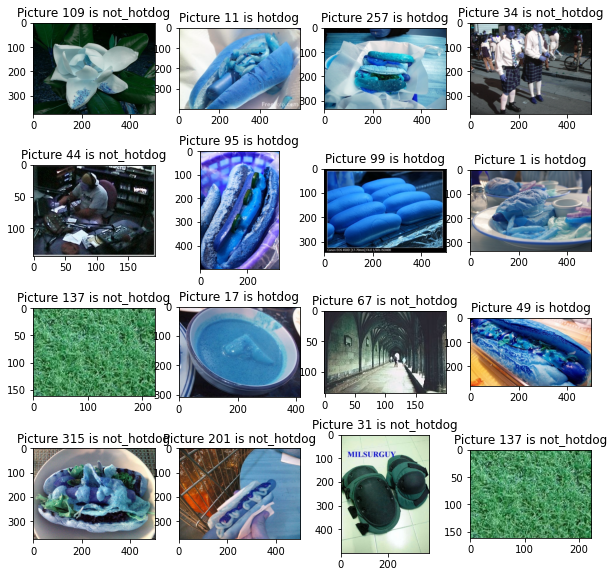

In [38]:
random_img = [randint(1, len(overall_predict)) for i in range(16)]
fig, axs = plt.subplots(4, 4, figsize=(10,10))
for i in range(4):
  for j in range(4):
    img = cv2.imread(testData[random_img[i*4+j]]) 
    img = np.array(img)
    if overall_predict[random_img[i*4+j]] == 0:
      text = "hotdog"
    else:
      text = "not_hotdog"
    axs[i, j].set_title(f"Picture {random_img[i*4+j]} is {text}")
    axs[i, j].imshow(img)

Выбираем случайным образом 16 тестовых фото и модем заметить, что большинство фото опредлено правильно